## Miyamoto Nagai disk
The Miyamoto Nagai potential is

$$
    \Phi(r,z) = -\dfrac{GM}{\sqrt{r^2 + \left(\sqrt{z^2+b^2}+a\right)^2}}
$$

And we can plot it in terms of $z/a$ and $R/a$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
def phi(r,z,a,b):
    return -1/(np.sqrt(r**2 + (np.sqrt(z**2+b**2) + a)**2))

$b/a \gg 1$ gives a spherical distribution, $b/a \ll 1$ gives a flattened distribution

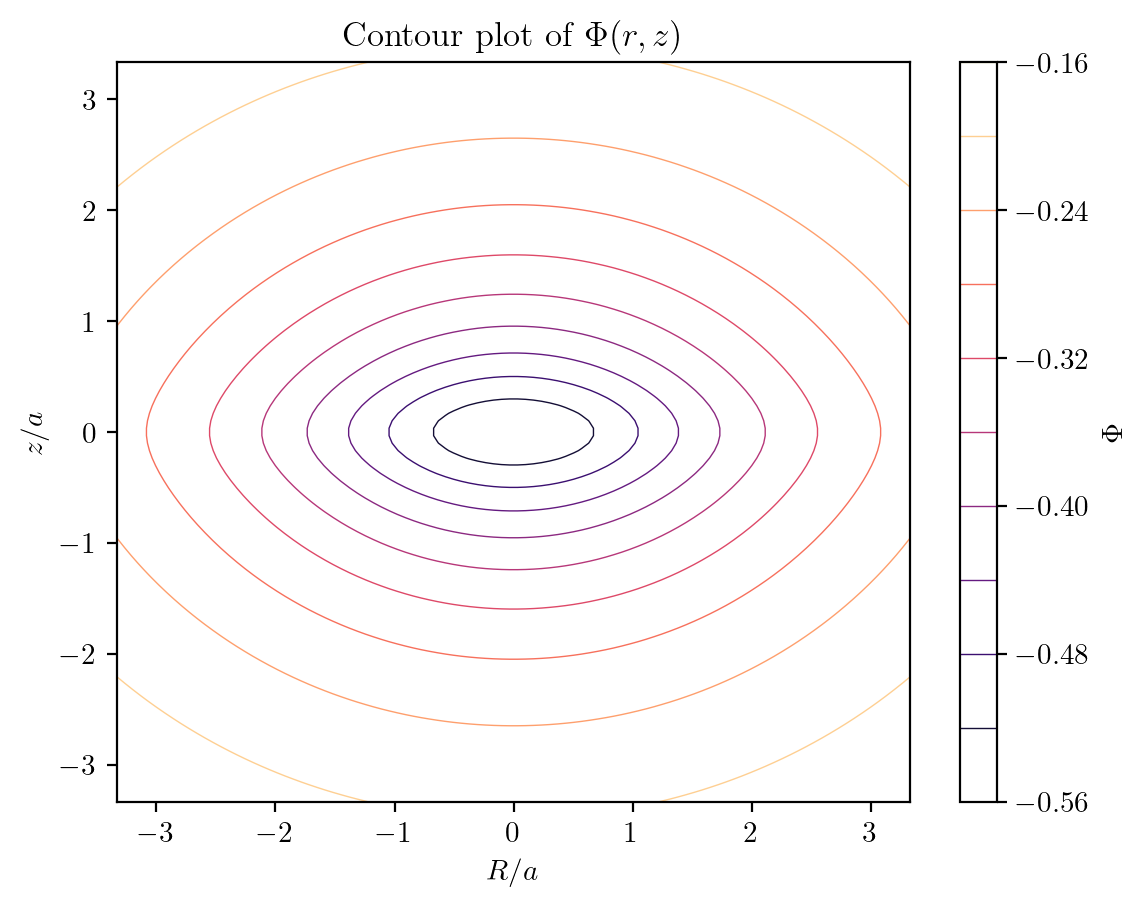

In [3]:
r = np.linspace(-5, 5, 100)
z = np.linspace(-5, 5, 100)
R, Z = np.meshgrid(r, z)

#constants
M = 1
G = 1
ratio = 0.2
a = 1.5
b = ratio*a

# Compute phi over the grid
Phi = phi(R/a, Z/a, a, b)

# Create the contour plot
plt.contour(R/a, Z/a, Phi, 10)
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.colorbar(label=r'$\Phi$')
plt.title(r'Contour plot of $\Phi(r, z)$')
plt.show()

Using the Poisson equation yields

$$
     \rho(R, z) = \left( \frac{b^2 M_\mathrm{tot}}{4 \pi} \right) \frac{a R^2 + \left( 3 \sqrt{z^2 + b^2} + a \right) \left( \sqrt{z^2 + b^2} + a \right)^2}{\left( R^2 + \left( \sqrt{z^2 + b^2} + a \right)^2 \right)^{5/2} \left( z^2 + b^2 \right)^{3/2}}.
$$

<br>

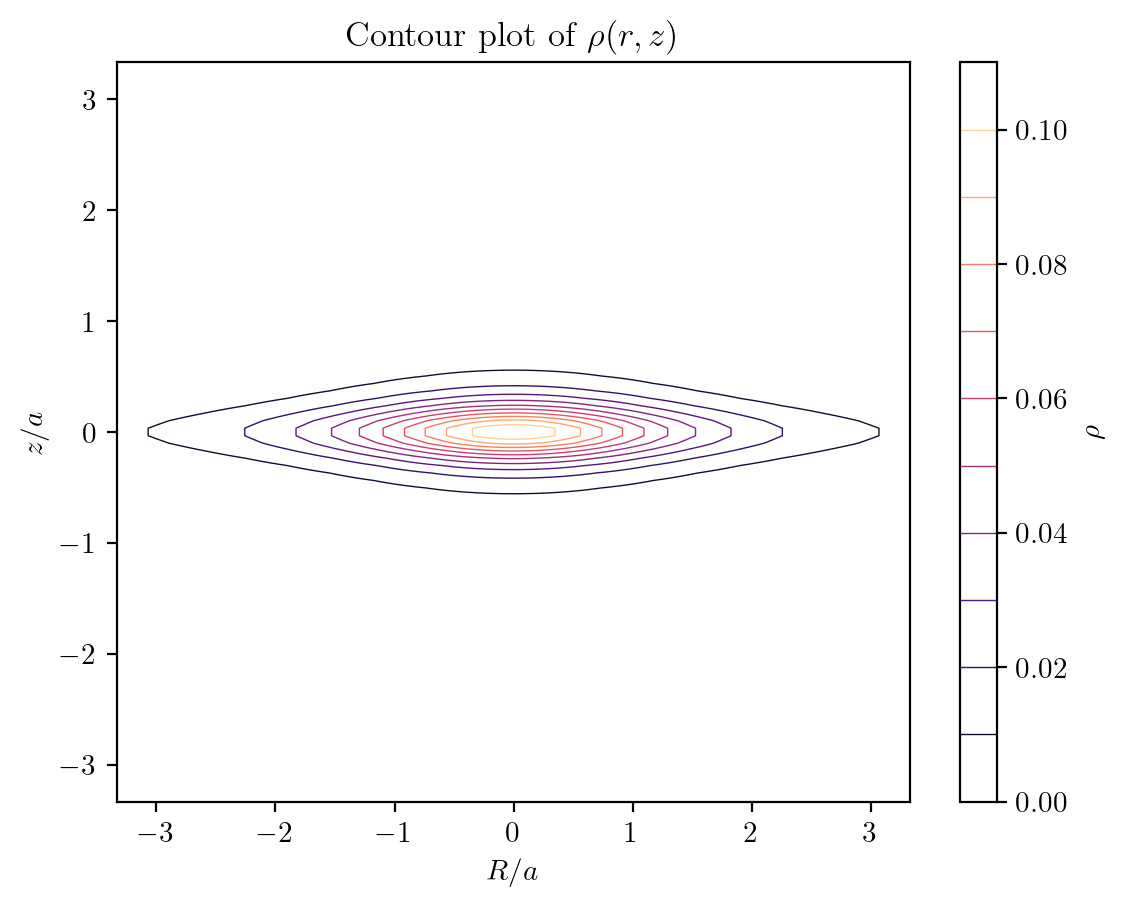

In [4]:
# Define the density function
def density(R, z):
    term1 = (b**2 * M) / (4 * np.pi)
    term2 = a * R**2 + (3 * np.sqrt(z**2 + b**2) + a) * (np.sqrt(z**2 + b**2) + a)**2
    term3 = (R**2 + (np.sqrt(z**2 + b**2) + a)**2)**(5/2)
    term4 = (z**2 + b**2)**(3/2)
    return term1 * term2 / (term3 * term4)


# Create the contour plot
plt.contour(R/a, Z/a, density(R/a,Z/a), 10)
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.colorbar(label=r'$\rho$')
plt.title(r'Contour plot of $\rho(r, z)$')
plt.show()

To initialize the Miyamoto-Nagai disk, we need to set the correct distributions for the particles' Cartesian coordinates. We will first find the distributions in cylindrical coordinates and then project them onto the Cartesian plane.

#### Mass Distribution

The mass enclosed within a radius \( r \) in cylindrical coordinates is:

$$
M(r) = \int_0^r \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R, z) R \, d\phi \, dz \, dR
$$

Where we also used that $dV = Rd\phi drdz$.

For our Monte Carlo approach we need to deal with probability distributions directly.

#### Radial Distribution

The cumulative distribution function (CDF) for the radial distance $R$ is:

$$
P(R) = \frac{M(R)}{M_{\text{total}}} = \frac{1}{M_{\text{total}}} \int_0^R \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R', z) R' \, d\phi \, dz \, dR'
$$

<br>

The probability density function (PDF) for the radial distance is, for the fundamental theorem of algebra:

<br>


$$
p(R) = \frac{dP(R)}{dR} = \frac{1}{M_{\text{total}}} \int_{-\infty}^{\infty} \int_0^{2\pi} \rho(R, z) R \, d\phi \, dz
$$

#### Azimuthal Distribution

Since the Miyamoto-Nagai potential is axisymmetric (independent of $\phi$), the azimuthal angle $\phi$ is uniformly distributed:

$$
P(\phi) = \frac{\phi}{2\pi}, \quad p(\phi) = \frac{1}{2\pi}
$$

#### Vertical Distribution

The distribution of $ z $ (or equivalently the polar angle $ \theta $) needs to account for the density profile. In cylindrical coordinates, $ z = r \cos \theta $.

The CDF for $ z $ is:

$$
P(z) = \frac{1}{M_{\text{total}}} \int_{-\infty}^z \int_0^\infty \int_0^{2\pi} \rho(R, z') R \, d\phi \, dR \, dz'
$$

The PDF for $ z $ is:

$$
p(z) = \frac{dP(z)}{dz} = \frac{1}{M_{\text{total}}} \int_0^\infty \int_0^{2\pi} \rho(R, z) R \, d\phi \, dR
$$

### Summary

To initialize the Miyamoto-Nagai disk, we follow these steps:

- Compute the radial CDF $ P(R) $ and PDF $ p(R) $.

- Use the uniform distribution $ p(\phi) $.

- Compute the vertical CDF $ P(z) $ and PDF $ p(z) $.

Using these distributions, we can sample the cylindrical coordinates $ (R, \phi, z) $ and then convert them to Cartesian coordinates for our simulations.

### Implementation
Integrating the density analytically is impossible, we would need to use numerical integration and then use interpolation to find the inverse of the CDF. Another possibility is instead to evaluate the pdf only and then use rejection method.

In [5]:
import sys
sys.path.insert(1, '../')
from gdsam import initial_data

In [6]:
disk = initial_data()
N = int(5e3)

### Rejection sampling

In [7]:
def pdf(r,z):
    return 1/M*density(r,z)

r_range = np.linspace(0,1,100)
z_range = np.linspace(-1,1,100)

R,Z = np.meshgrid(r_range, z_range)

g = np.max(pdf(R,Z))

print(f'the maximum of the distribution is {g:.3f}')

the maximum of the distribution is 0.109


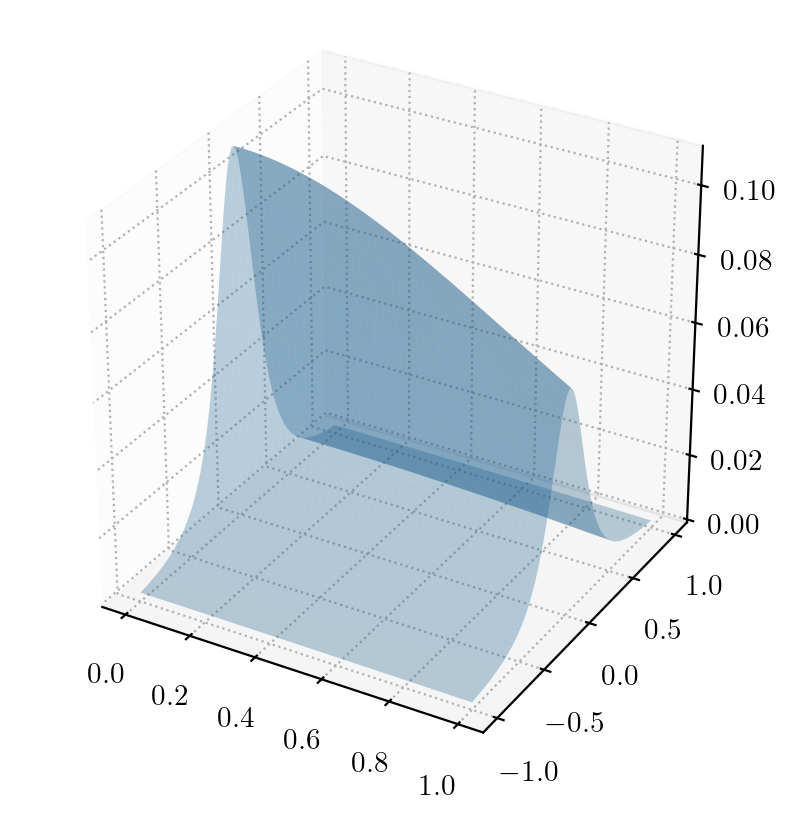

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "aspect":"equal"})

ax.plot_surface(R,Z, pdf(R,Z), alpha=0.3);

Since the probability is almost 0 outside the range shown we can perform a rejection sampling that's limited in range.

In [9]:
def rejection_sampling(f, r_max, z_max, num_samples):
    r_samples, z_samples = ([],[])
    
    r_test = np.linspace(.01, r_max, int(1e6))
    z_test = np.linspace(-z_max, z_max, int(1e6))
    y = f(r_test, z_test)
    g = np.max(y)
    
    with tqdm(total=num_samples, desc='Sampling') as pbar:
        while len(r_samples) < num_samples:
            
            r_i = np.random.uniform(0, R_max)
            z_i = np.random.uniform(-z_max, z_max)
            
            u = np.random.uniform(0, 1)
            
            # Accept or reject the candidate
            if u < f(r_i, z_i) / g: 
                r_samples.append(r_i)
                z_samples.append(z_i)
                pbar.update(1)
                
    return np.array(r_samples), np.array(z_samples)

In [10]:
R_max = 100
z_max = 10
R_samples, z_samples = rejection_sampling(pdf, R_max, z_max, N)

Sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
disk.N = N
disk.m = np.full(N, M / N)
disk.r = R_samples
disk.z = z_samples
disk.theta = 2*np.pi*np.random.uniform(0,1,N)

disk.x = disk.r * np.cos(disk.theta)
disk.y = disk.r * np.sin(disk.theta)
disk.z = disk.z

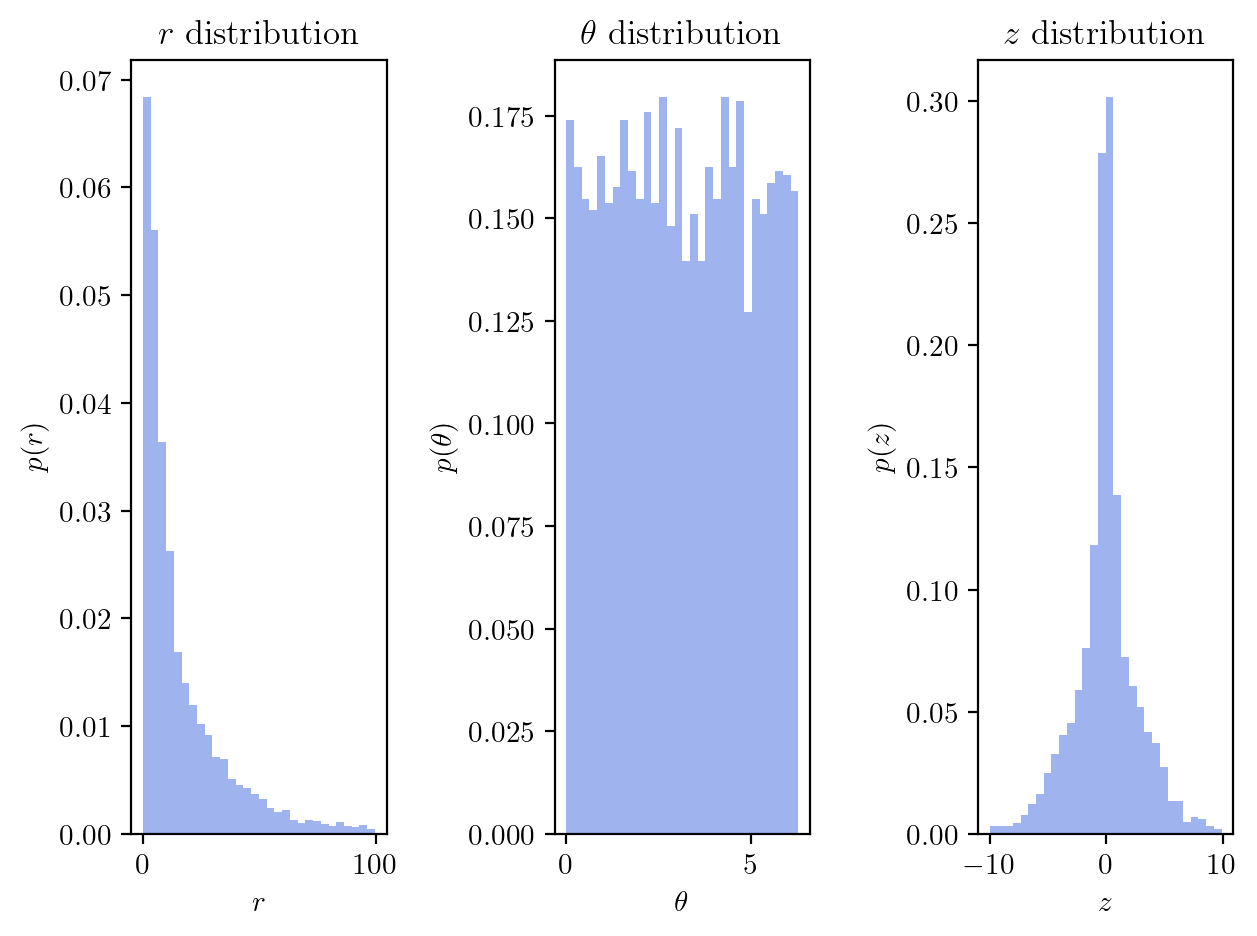

In [12]:
disk.show_dist_cyl();

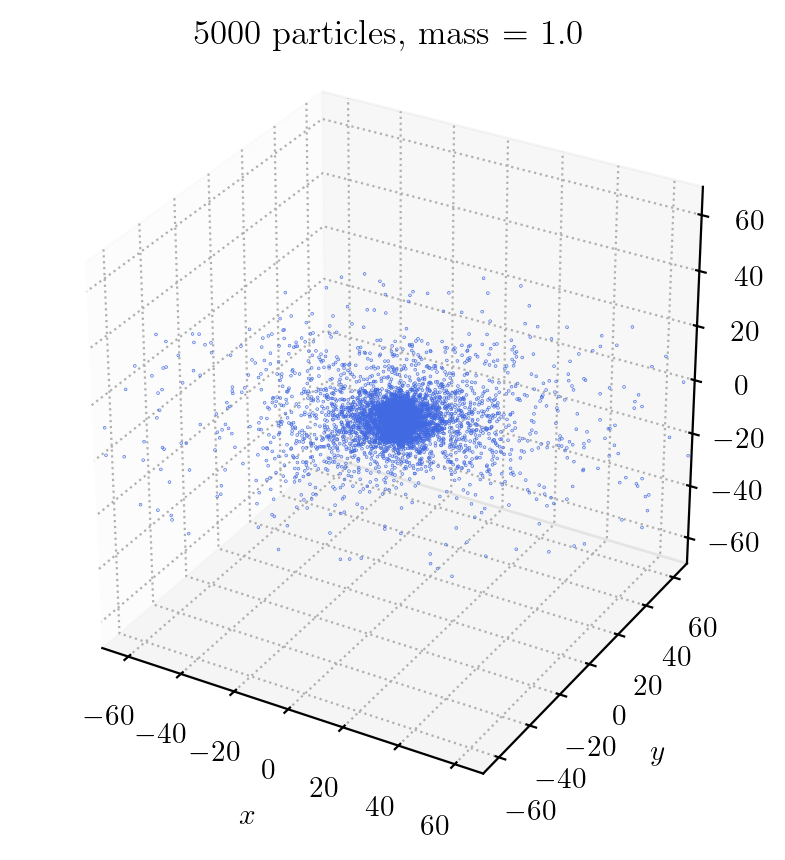

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
disk.positions_3d(ax, l=70, s=.05, a=1)
plt.show()

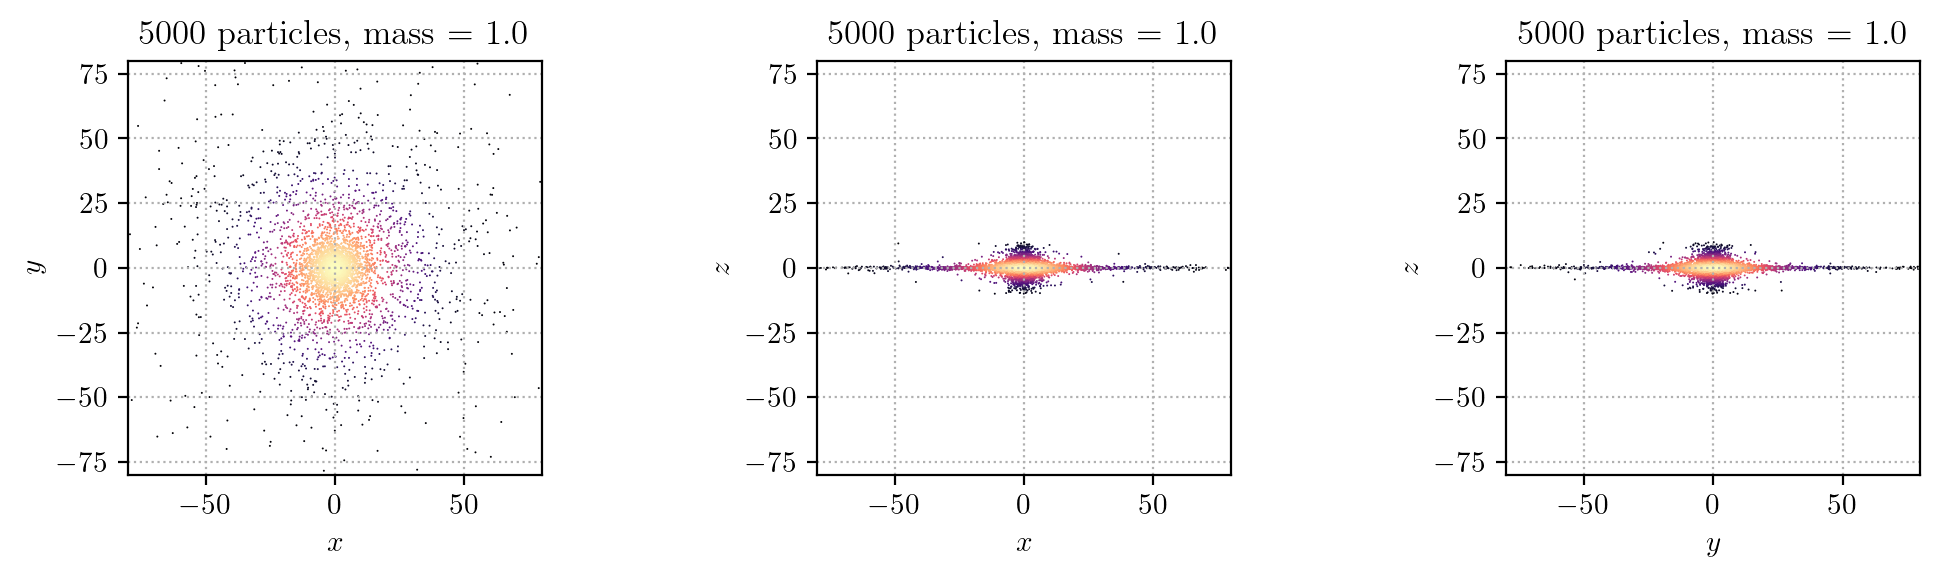

In [14]:
disk.projections(l=80, s=.5, a=1);

## Setting the velocities

We will use the Toomre stability criterion and choose to initialize a distribution with $Q = 5$. This choice is completely arbitrary

To have circular orbits we need

$$
            F_\mathrm{cp} = F_\mathrm{G} \quad \longrightarrow \quad \omega^2R = \dfrac{GM(R)}{R^2} \quad \longrightarrow \quad \dot{\theta}^2 = \frac{GM(R)}{R^3}
$$

For the mass we need to integrate the density, and since the integration really hard we will instead calculate the mass within each radius of the disk and then interpolate the function

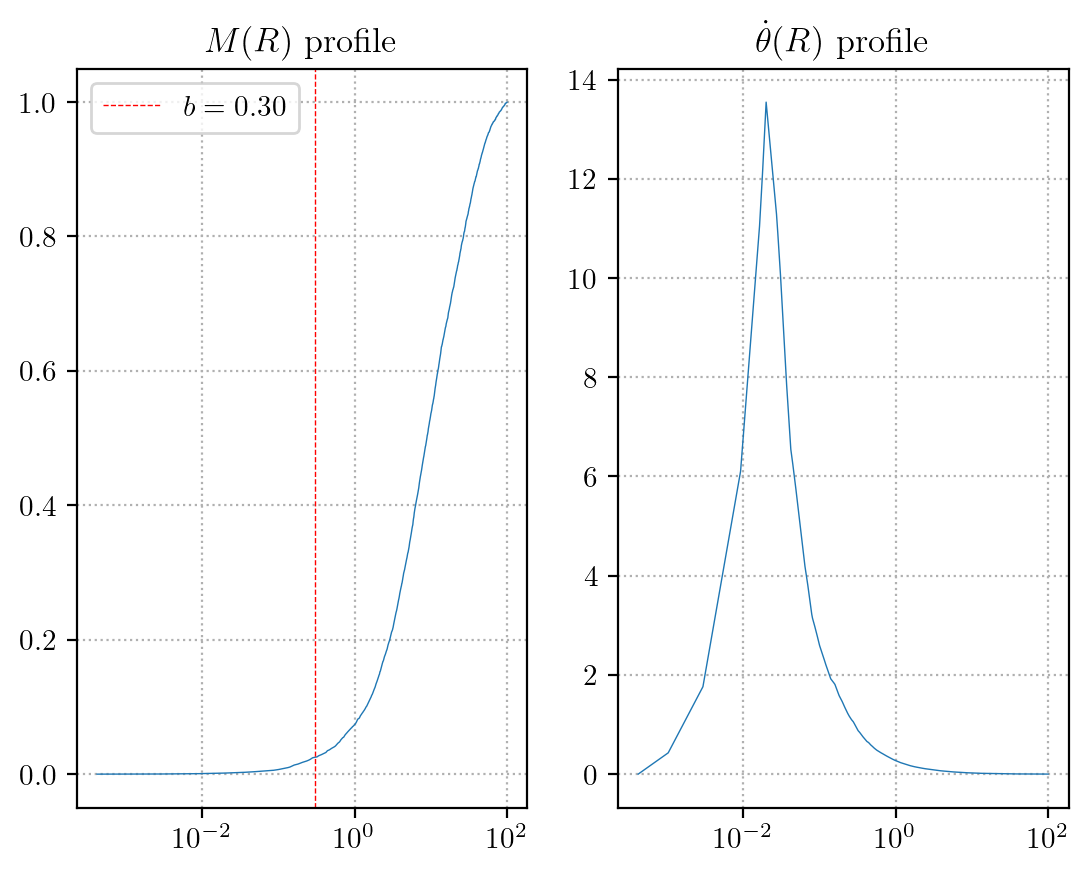

In [15]:
from scipy.interpolate import interp1d

R = np.sort(disk.r) #the radius we sampled from the distribution

scan = np.linspace(min(R), 2*max(R), int(1e4))
M_inside = np.array([np.sum(disk.m[disk.r<r_i]) for r_i in scan])
theta_inside = np.sqrt(G*M_inside/scan**3) #angular velocity

M_r = interp1d(scan, M_inside)
theta_dot = interp1d(scan, theta_inside)


fig, axs = plt.subplots(1,2)

axs[0].plot(R, M_r(R))
axs[0].axvline(b,-1,2, c='r', ls='--', label= fr'$b={b:.2f}$')
axs[0].set(title=fr'$M(R)$ profile', xscale='log')
axs[1].plot(R, theta_dot(R))
axs[1].set(title=fr'$\dot \theta(R)$ profile', xscale='log')

axs[0].legend()
[ax.grid() for ax in axs]

plt.show()

The Toomre parameter is defined as 
$$
Q=\frac{\sigma k}{G\Sigma}
$$
We can define $k$, the epicyclic frequency, as 

$$
k^2=\frac{\partial\Phi_{eff}}{\partial R^2}\Big|_{0,0} = \frac{\partial}{\partial R}\left(\frac{\partial}{\partial R}\left(\Phi + \frac{l_z^2}{2R^2}\right)\right)\Big|_{0,0} = 4\pi G \Sigma - \frac{\partial}{\partial R}\left(\frac{l_z^2}{R^3}\right) = 4\pi G \Sigma + \frac{3 l_z^2}{R^4}
$$
<br>
Remember, for a general potential you must derive the epicyclic and angular frequency first, then the orbital frequency is a function of them.

In this case we can substitute $l_z$, angular momentum per unit mass, as

$$
    l_z = \omega r^2 = \dot \theta R^2
$$

Therefore we get
$$k^2 = 4\pi G \Sigma + 3 \dot{\theta}^2$$

We can find sigma by simply putting $\rho(R, z=0)$

$$ 
\Sigma(R) = \rho(R, z=0) = \left( \frac{M_\mathrm{tot}}{4 \pi b} \right) \frac{a R^2 + \left( 3b + a \right) \left(b + a \right)^2}{\left( R^2 + \left( b + a \right)^2 \right)^{5/2}}
$$

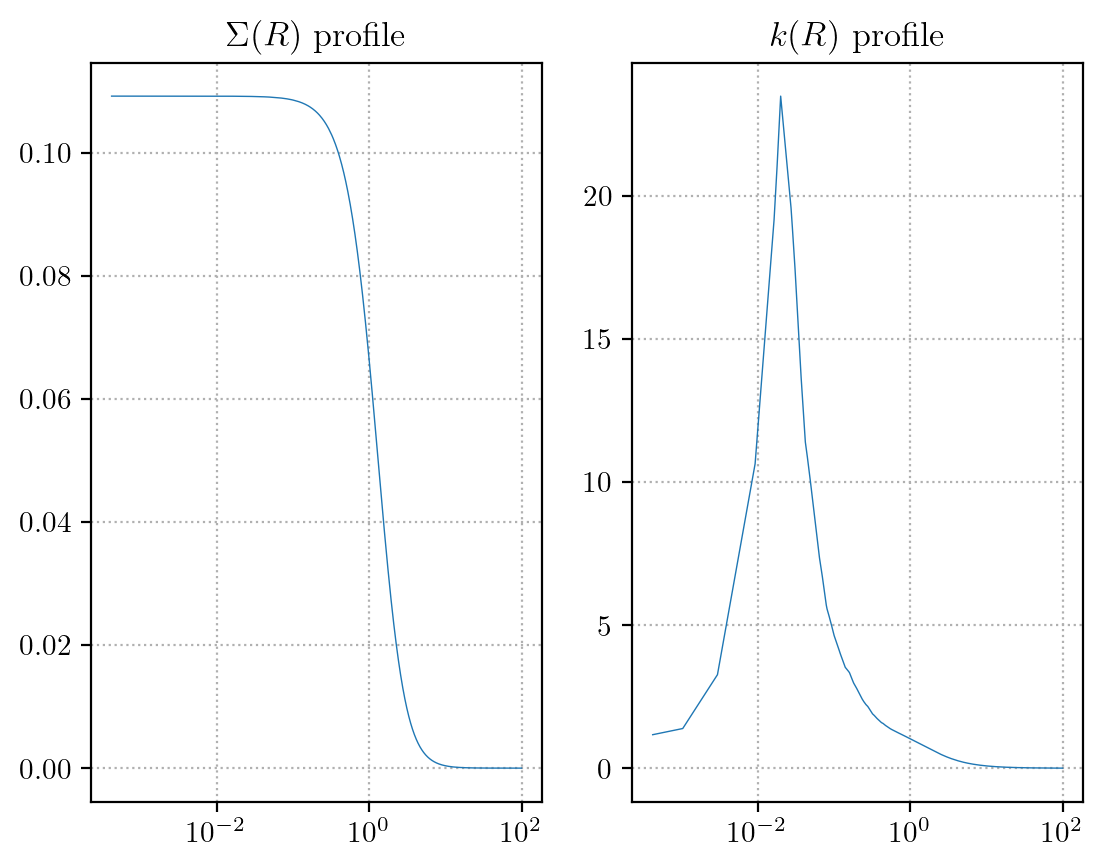

In [16]:
term1 = (M/(4*np.pi*b))
term2 = (a*R**2 + (3*b+a)*(b+a)**2)
term3 = (R**2+(b+a)**2)**(5/2)

sigma = term1*term2/term3
k = np.sqrt(4*np.pi*sigma + 3*theta_dot(R)**2)

fig, axs = plt.subplots(1,2)

axs[0].plot(R, sigma)
axs[0].set(title=fr'$\Sigma(R)$ profile', xscale='log')
axs[1].plot(R, k)
axs[1].set(title=fr'$k(R)$ profile', xscale='log')

[ax.grid() for ax in axs]

plt.show()

Now we have an expression for $k$ and $\Sigma$. We can vary the Toomre parameter in a descending manner, that way we will have instability inside and stability outside, or the opposite. We can emply different approaches

In [17]:
Q = np.full(N, 5)

Let's now compute $\sigma$ inverting the relation from the Toomre parameter definition

$$
    \sigma = \dfrac{G\ \Sigma(R)}{k}\ Q
$$

In [18]:
v_disp = (G*sigma/k)*Q #velocity dispersion a.k.a sigma
print(v_disp)

[0.4660112  0.3934682  0.16697173 ... 0.00071084 0.00071038 0.0007062 ]


We can use the dispersion as the standard deviation of a gaussian distribution centered around the circular velocities at every radius. The expression for those velocities in the cartesian plane is

$$
\dot{x}= \dfrac{d}{dt}\left(R \cos \theta \right) = \dot{R}\ \cos \theta - R \sin \theta\dot{\theta} = - R \sin \theta\dot{\theta}
$$ 

$$
\dot{y}=\dfrac{d}{dt}\left(R \sin \theta \right) = \dot{R}\sin \theta + R \cos \theta\dot{\theta} = R \cos \theta\dot{\theta}
$$

$$
\dot{z}=\dfrac{dz}{dt} = 0 
$$
<br>

where $\dot R = 0$  since circular orbits and $\dot{z} = 0 $ due to $z=0$ for the Kuzmin distribution.

In [19]:
x_dot = -R*np.sin(disk.theta)*theta_dot(R)
y_dot = +R*np.cos(disk.theta)*theta_dot(R)

In [20]:
#each v_x is sampled from a different gaussian centered in x_dot[i] with dispersion v_disp[i]
v_x     = np.random.normal(x_dot, v_disp)
v_y     = np.random.normal(y_dot, v_disp)
v_z     = np.zeros(N)

In [21]:
i = np.random.randint(0,N)
print(f'Percentual dispersion for the {i}th particle {abs(v_disp[i]/x_dot[i]*100):.2f} %')

Percentual dispersion for the 4752th particle 1.31 %


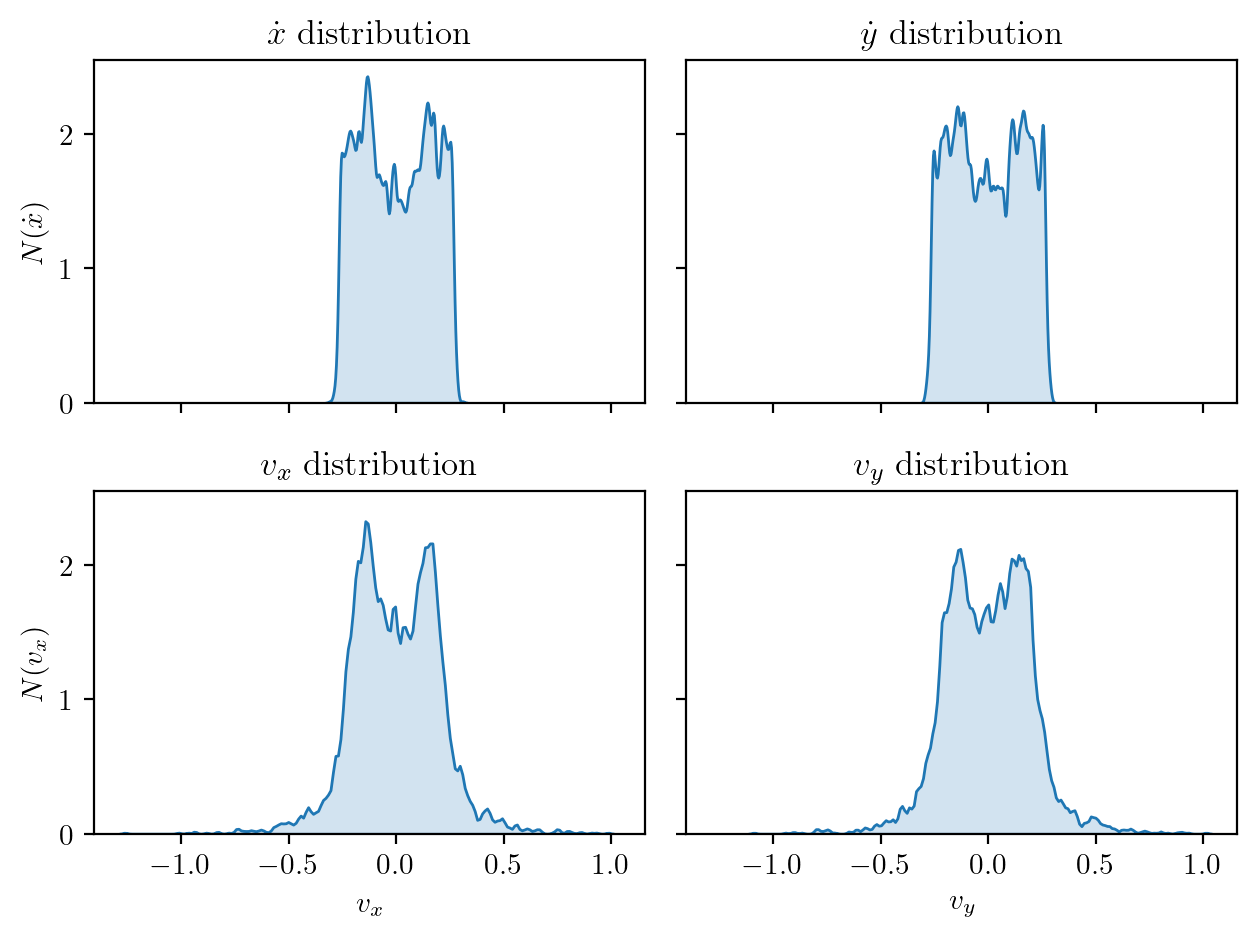

In [22]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, tight_layout=True, sharex=True, sharey=True)

sns.kdeplot(x_dot, ax=axs[0, 0], fill=True, alpha=0.2, bw_adjust=0.25)
axs[0, 0].set(title=fr'$\dot x$ distribution', xlabel=r'$\dot x$', ylabel=r'$N(\dot x)$')

sns.kdeplot(y_dot, ax=axs[0, 1], fill=True, alpha=0.2, bw_adjust=0.25)
axs[0, 1].set(title=fr'$\dot y$ distribution', xlabel=r'$\dot y$', ylabel=r'$N(\dot y)$')

sns.kdeplot(v_x, ax=axs[1, 0], fill=True, alpha=0.2, bw_adjust=0.25)
axs[1, 0].set(title=fr'$v_x$ distribution', xlabel=r'$v_x$', ylabel=r'$N(v_x)$')

sns.kdeplot(v_y, ax=axs[1, 1], fill=True, alpha=0.2, bw_adjust=0.25)
axs[1, 1].set(title=fr'$v_y$ distribution', xlabel=r'$v_y$', ylabel=r'$N(v_y)$');

In [23]:
disk.set_velocities(v_x,v_y,v_z)

---

In [32]:
home = '../../'
input = home + f'data/inputs/MN-disk{N}.txt' 
output = home + f'data/outputs/MN-disk{N}.txt'
log = f'../../data/outputs/MN-disk{N}_log.txt'

In [33]:
open(output, 'w').close() #clearing output file
disk.write_tree(input)

Now we calculate the softening and accuracy parameters. The softening must be calculated for the volume of the disk. We know the density is the mass per unit volume, so the volume will be the given by

$$
    V = \dfrac{M_\mathrm{tot}}{\rho_\mathrm{tot}} = \dfrac{1}{\mathrm{pdf}(R,Z)}
$$

where $R,Z$ represent the maximum radius and height of the distribution

In [34]:
R = np.max(disk.r)
Z = np.max(disk.z)

V = 1/pdf(R,Z)
print(f'{V:.2e}')

7.33e+10


In [35]:
epsilon = 1/100 * (V/int(float(N)))**(1/3)
print(f'{epsilon:.3f}')

2.447


In [36]:
T_sim = 400
dt = 0.5
theta = 0.1

In [37]:
print(f'T_sim = {T_sim:.1f} \t epsilon = {epsilon:.2e} \t dt = {dt:.2f}')

T_sim = 400.0 	 epsilon = 2.45e+00 	 dt = 0.50


In [38]:
os.system(home + f'treecode/tree/treecode in={input} out={output} eps={epsilon} tstop={T_sim} dtout={dt}>{log}')

0

In [39]:
import gdsam

pl = gdsam.plotter()
pl.get_data_tree(output)

Loaded 5e+03 particles


  0%|          | 0/401 [00:00<?, ?it/s]

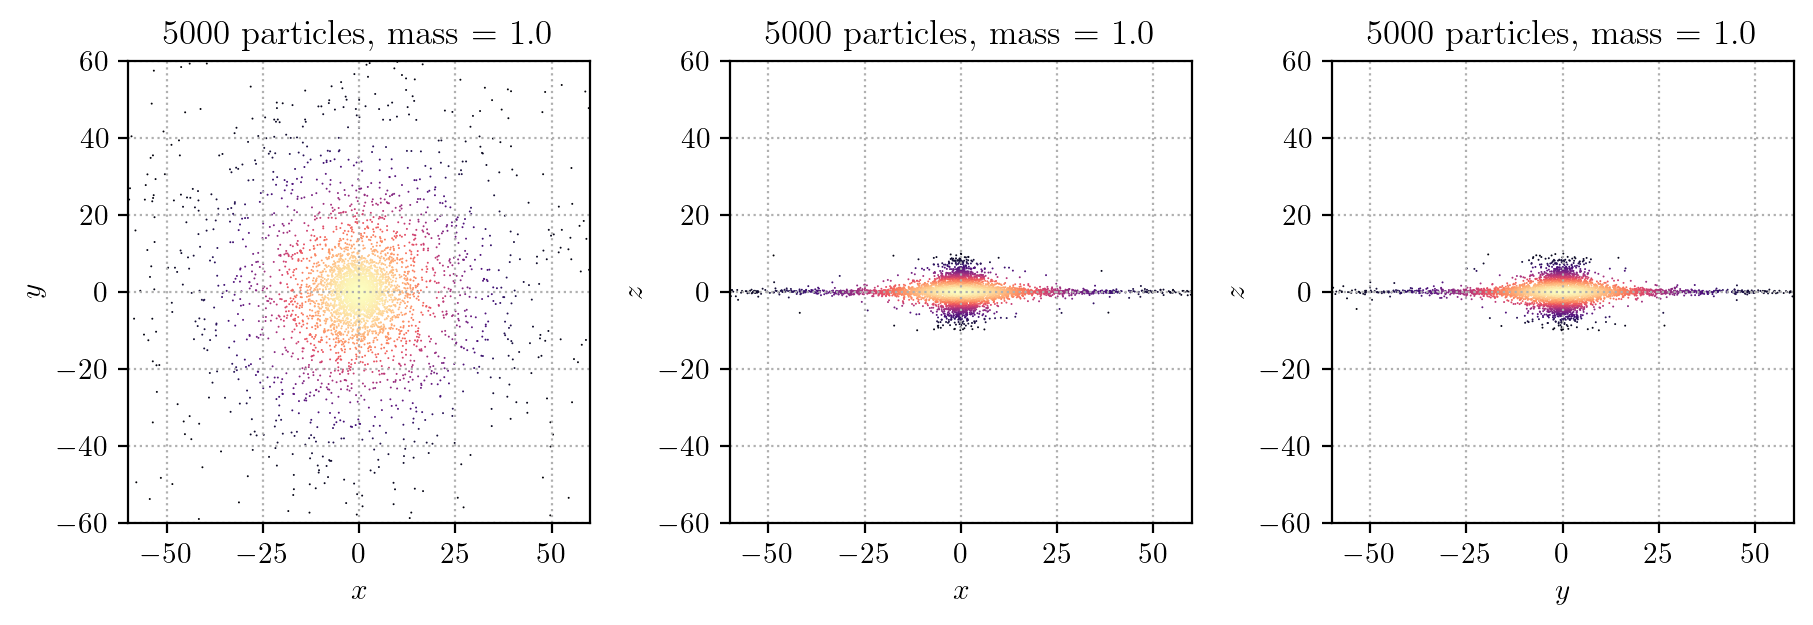

In [42]:
fig, axs = plt.subplots(1,3, figsize=(11,3))
ani = pl.animate_projections(fig, axs, b=0, l=60, s=.5, a=1, frame_skip=2)

ani.save(f'../media/disk{N}.mp4', dpi=300, fps=30)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 399

x_cm, y_cm ,z_cm = pl.x_cm, pl.y_cm, pl.z_cm
pl.positions_3d(ax, num=i, l=60, b=0, a=.1, s=.5)
ax.scatter(x_cm[i], y_cm[i], z_cm[i], s=20, c='r');

In [ ]:
pl.projections(num=i, s=.5, a=1, b=0, l=80);

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ani = pl.animate_3d(fig, ax, b=0, l=60, s=.5, a=.1, frame_skip=4)

ani.save(f'../media/disk{N}.mp4', dpi=300, fps=30)

In [43]:
from IPython.display import Video

Video(filename=f'../media/disk{N}.mp4', width=600)